# Churn Prediction Model with Logistic Regression

If you owned a service providing company with a variety of customers and clients, and could know which of your clients were more likely to churn i.e stop using your service, based on their profiles, that'd be cool right?

If you could predict which of your customers had intentions of churning, you could gift them some discounts and other waivers to retain them right, right? Marketing and Customer service departments of such companies will be so happy to have this, so, why not build them one?!

This project is broken into parts- In this article, we'll start right from pre-processing our data, to building our model. The next article will teach how to create a virtual environment for the model, serve with Flask, deploy and containerize with Docker!

To follow up easily, you'll need a basic knowledge of Python syntax, basic maths, numpy, pandas and visualization libraries like matplotlib. We'll also use Scikit-Learn's Logistic Regression algorithm to train our model and then evaluate the model's performance. Packed but definitely exciting :)



***

#### _Loading and Pre-processing Dataset_
You need to install Anaconda and launch a new notebook from Jupyter Notebook and then load project dependencies

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

- Numpy helps us perform mathematical computations and has more flexibilities than using raw Python Lists
- Pandas helps us work with our dataframe and dataframe formatting
- Matplotlib for visualization
- We import train_test_split from Scikit learn's model selection module to help us split our dataset into
    - 60% Train dataset to train our model
    - 20% Validation dataset to validate the trained model
    - 20% Test dataset to test performance of our model
- DictVectorizer spreads out categorical features from our dataset into dictionaries and encodes them
- LogisticRegression algorithm for our model
- ROC is a performance evaluation metric.

In [95]:
#load dataset from copy downloaded from kaggle and view first 5 entires

df = pd.read_csv(r"C:\Users\H P\Desktop\Machine Learning Zoomcamp\Logistic Regression\Telco-Customer-Churn.csv") 
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### _Data Cleaning_

- First, we need to make all our text inputs uniform. Either make all texts uppercase or lowercase and fill spaces with a uniform symbol. 
Let's format column names and all inputs to lowercase, and fill spaces with (_) symbol.
- Next, we convert all expected columns misclassified back to their appropriate categories. The column "Total Charges" is assigned an object datatype.
  We convert it back to Int(Integer)
- Next, our churn column, which is our target column, is converted from bool to Int, 0= No, 1= Yes
- Finally fill our missing values from Total Charges column with (0)

In [96]:
###formats column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

###formats all index by removing spaces and making index lowercase. ie formats rows
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors = 'coerce')  #changes object dtypes to int and second input ignores nulls, and  other dtypes included

df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)  #assigns 0 and 1 to yes and no

Let's verify if the code above worked

In [97]:
df.head()

##yess it did!

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1


In [98]:
df.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

We separate our features into categorical and numerical

In [99]:
numerical = ['tenure','monthlycharges', 'totalcharges' ]

categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
     'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

***

#### Exploratory Data Analysis

Let's check the variety of entries from the dataset and then a statistical description

In [100]:
for col in df.columns:
    print(col) #prints column then
    print(df[col].unique()[:5])#print first 5 unique values of col
    print(df[col].nunique()) #prints total number of different values of col

customerid
['7590-vhveg' '5575-gnvde' '3668-qpybk' '7795-cfocw' '9237-hqitu']
7043
gender
['female' 'male']
2
seniorcitizen
[0 1]
2
partner
['yes' 'no']
2
dependents
['no' 'yes']
2
tenure
[ 1 34  2 45  8]
73
phoneservice
['no' 'yes']
2
multiplelines
['no_phone_service' 'no' 'yes']
3
internetservice
['dsl' 'fiber_optic' 'no']
3
onlinesecurity
['no' 'yes' 'no_internet_service']
3
onlinebackup
['yes' 'no' 'no_internet_service']
3
deviceprotection
['no' 'yes' 'no_internet_service']
3
techsupport
['no' 'yes' 'no_internet_service']
3
streamingtv
['no' 'yes' 'no_internet_service']
3
streamingmovies
['no' 'yes' 'no_internet_service']
3
contract
['month-to-month' 'one_year' 'two_year']
3
paperlessbilling
['yes' 'no']
2
paymentmethod
['electronic_check' 'mailed_check' 'bank_transfer_(automatic)'
 'credit_card_(automatic)']
4
monthlycharges
[29.85 56.95 53.85 42.3  70.7 ]
1585
totalcharges
[  29.85 1889.5   108.15 1840.75  151.65]
6531
churn
[0 1]
2


In [101]:
df.describe()

,seniorcitizen,tenure,monthlycharges,totalcharges,churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304,0.265370
std,0.368612,24.559481,30.090047,2266.794470,0.441561
min,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,9.000000,35.500000,398.550000,0.000000
50%,0.000000,29.000000,70.350000,1394.550000,0.000000
75%,0.000000,55.000000,89.850000,3786.600000,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


<Axes: xlabel='churn', ylabel='Count'>

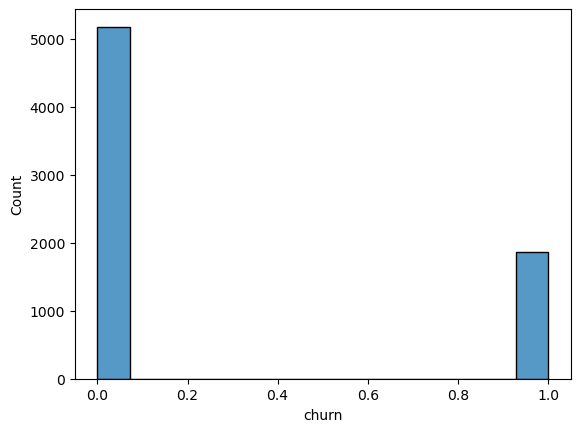

In [102]:
import seaborn as sns

sns.histplot(df.churn)

It's observed that there are more non-churning people from our dataset than churning customers. This explains that more people are satisfied with the services of the Telco Company. It will be great to learn why some of our clients are churning, and gift them discounts

*** 

#### Setting Up Validation Framework

Now, split our dataset into 3 parts, 60% as training dataset, 20% as validation dataset and 20% as a testing dataset, using sklearn's train_test_split.


In [103]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1) ##splits test to 20%
df_train, df_val =train_test_split(df_full_train, test_size=0.25, random_state=1)

In [104]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

##realign the indexes of the split data

In [105]:
y_train = df_train.churn.values
y_test = df_test.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

##assign y values(churn values to separately to each set) and delete churn values from main df

In [106]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(4225, 20)
(1409, 20)
(1409, 20)


Great We're all set. We have our X values for each split, we have targets values assigned. Next is to import and use our Binary Classification 
(Logistic Regression) algorithm

***

#### Encoding and Fitting Model

Parse our df through DictVectorizer to encode column features and transform the matrix

In [107]:
train_dicts = df_train[categorical + numerical].to_dict(orient = 'records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_train

array([[0.00000e+00, 0.00000e+00, 1.00000e+00, ..., 1.00000e+00,
        7.20000e+01, 8.42515e+03],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        1.00000e+01, 1.02155e+03],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        5.00000e+00, 4.13650e+02],
       ...,
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        2.00000e+00, 1.90050e+02],
       [0.00000e+00, 0.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        2.70000e+01, 7.61950e+02],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        9.00000e+00, 7.51650e+02]])

In [108]:
X_train.shape

##we do same for Val dataset

(4225, 45)

In [109]:
val_dicts = df_val[categorical + numerical].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)


In [110]:
X_val.shape

(1409, 45)

Using our model to train the encoded df, with their target values...

In [111]:
model = LogisticRegression(solver='lbfgs', max_iter=10000)  #initiates an instance
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

Toodles! Our model is trained!


***

#### Validating and Testing Model

To check the performance of our model, we try it against our validation dataset, and again compare its accuracy againt our test dataset.
We encode our val dataset and transform into matrix like above.

In [115]:
val_dicts = df_val.fillna(0).to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

test_dicts = df_test.fillna(0).to_dict(orient = 'records')
X_test = dv.transform(test_dicts)

After encoding our val and test dataframes, we now pass them to our model for prediction.

Then use ROC_AUC score to calculate model accuarcy for both predictions on Val dataset, and test dataset

In [118]:
y_pred_val = model.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred_val)

0.8464639711505832

In [120]:
y_pred_test = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_test)

0.8572304917286879

#### _Model ROC AUC SCORE_

Our model achieved 85% score !! Impressive! We can tune certain features and add regularization values to further increase model performance.

Our model is good enough for deployment. 

In the next article, I'll walk you through the process of serving this Model with Flask, creating an environment, containerization with Docker,
and deploying to the cloud using AWS Elastic Beanstalk!!
    

#### _Happy Learning :)_